In [ ]:
import random
import os
import sys
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import numpy as np
import torch
import torchvision
from torch import nn
import albumentations as A
from torchvision import models
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn.metrics.cluster import homogeneity_score, completeness_score

**Dataset Downloader**

In [ ]:
dataset = torchvision.datasets.MNIST('/content/', train=True, download=True)
dataset

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/
    Split: Train

**Augmentation**

In [ ]:
alb_transforms = A.Compose(
    [
        # A.HorizontalFlip(),
        A.Rotate(limit=40, p=0.7),
        # A.IAAPerspective(scale=(0.1, 0.1), p=0.7),
        A.IAASuperpixels(p_replace=0.3, p=0.7),
        # A.IAAAdditiveGaussianNoise(scale=(0.1 * 255, 0.2 * 255), p=0.7),
        A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.6, p=0.7),
    ]
)

**DatasetLoader**

In [ ]:
class DatasetLoader(Dataset):
    def __init__(self, dataset, split, train = True, alb_transforms=None):
      if train:
        data = dataset.data[:split_length]
        self.label = dataset.targets[:split_length]
      else:
        data = dataset.data[split_length:]
        self.label = dataset.targets[split_length:]
      
      self.transform = False
      
      if alb_transforms is not None:
        self.transform = True
        data_alb = []
        data_image = []
        for image in tqdm(data):
          image_np = image.cpu().detach().numpy()
          # normalizing image
          image = image.float()
          # mean, std = torch.mean(image), torch.std(image)
          # image = (image-mean)/std
          # transforming and normalizing image
          image_alb = alb_transforms(image=image_np)["image"]
          image_alb = torch.from_numpy(image_alb)
          image_alb = image_alb.float()
          # mean, std = torch.mean(image_alb), torch.std(image_alb)
          # image_alb = (image_alb-mean)/std
          # image channel correction
          if len(image.shape) < 3:
            image = image.unsqueeze(0)
            image_alb = image_alb.unsqueeze(0)
          else:
            image = image.movedim(2,0)
            image_alb = image_alb.movedim(2,0)
          data_image.append(image)
          data_alb.append(image_alb)
          del image_np
        
        self.data_alb = torch.stack(data_alb)
        self.data = torch.stack(data_image)
      
      else:
        data_image = []
        for image in tqdm(data):
          # normalizing image
          image = image.float()
          # mean, std = torch.mean(image), torch.std(image)
          # image = (image-mean)/std
          # image channel correction
          if len(image.shape) < 3:
            image = image.unsqueeze(0)
          else:
            image = image.movedim(2,0)
          data_image.append(image)
        self.data = torch.stack(data_image)


    def __len__(self):
      return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.label[idx]

        if self.transform:
          image_alb = self.data_alb[idx]
          return (image, image_alb, label)
        else:
          return (image, label)

In [ ]:
split_length = int(0.95*len(dataset))
print("Train dataset: ", split_length)
print("Test dataset: ", len(dataset)-split_length)
# training data
print("Training Dataset --->")
trainDatasetLoader = DatasetLoader(dataset, split_length, train = True,
                                   alb_transforms=alb_transforms)
dataloader_train = DataLoader(trainDatasetLoader, batch_size=1024, shuffle=True, num_workers=0)
# validation data
print("Validation Dataset --->")
valDatasetLoader = DatasetLoader(dataset, split_length, train = False,
                                   alb_transforms=alb_transforms)
dataloader_val = DataLoader(valDatasetLoader, batch_size=1024, shuffle=True, num_workers=0)

Train dataset:  57000
Test dataset:  3000
Training Dataset --->


  0%|          | 0/57000 [00:00<?, ?it/s]

Validation Dataset --->


  0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
val = next(iter(dataloader_train))
print(val[0].shape)
print(val[1].shape)
print(val[2].shape)
del val

torch.Size([1024, 1, 28, 28])
torch.Size([1024, 1, 28, 28])
torch.Size([1024])


**Model**

In [ ]:
class ResNetClusterisator(nn.Module):
    def __init__(self):
        super(ResNetClusterisator, self).__init__()
        final_features = 512
        resnet = models.resnet18(pretrained=False)
        modules = list(resnet.children())[:-2]
        modules[0] = nn.Conv2d(
            1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        modules.append(nn.Flatten())
        self.backbone = nn.Sequential(*modules)
        self.cluster_head = nn.Linear(final_features, 10)
        self.overcluster_head = nn.Linear(final_features, 50)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x, overclustering=False):
        x = self.backbone(x)
        if overclustering:
            x = self.overcluster_head(x)
        else:
            x = self.cluster_head(x)
        return self.softmax(x)

In [ ]:
# weight initializer
def weight_init(model):
    if isinstance(model, nn.Conv2d):
        nn.init.xavier_normal_(model.weight, gain=nn.init.calculate_gain("relu"))
        if model.bias is not None:
            nn.init.zeros_(model.bias)

    elif isinstance(model, nn.Linear):
        nn.init.xavier_normal_(model.weight)
        if model.bias is not None:
            nn.init.zeros_(model.bias)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)
model = ResNetClusterisator()
model.to(device)
print("The model is transfered to", device)
model.apply(weight_init)
print("The weights are Initialised.")

Using cuda


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


The model is transfered to cuda
The weights are Initialised.


In [ ]:
val = next(iter(dataloader_train))
input_batch = val[0]
input_batch = input_batch.to(device)
print("Model output shape in clustering mode:", model(input_batch).shape)
print("Model output shape in overclustering mode:", model(input_batch, overclustering=True).shape)

Model output shape in clustering mode: torch.Size([1024, 10])
Model output shape in overclustering mode: torch.Size([1024, 50])


**Loss**

In [ ]:
def IID_loss(x_out, x_tf_out, lamb=1.0, EPS=sys.float_info.epsilon):
    _, num_classes = x_out.size()
    # shape: [1024,10,1] * [1024,1,10] => [1024,10,10]
    p_i_j = x_out.unsqueeze(2) * x_tf_out.unsqueeze(1)
    # shape: [10,10]
    p_i_j = p_i_j.sum(dim=0)
    p_i_j = (p_i_j + p_i_j.t()) / 2.0
    p_i_j = p_i_j / p_i_j.sum() # Normalization
    assert p_i_j.size() == (num_classes, num_classes)
    
    # shape: [10,1] -> [10,10]
    p_i = p_i_j.sum(dim=1).view(num_classes, 1).expand(num_classes, num_classes).clone()
    p_j = p_i_j.sum(dim=0).view(1, num_classes).expand(num_classes, num_classes).clone()
    # avoid NaN losses. Effect will get cancelled out by p_i_j tiny anyway
    p_i_j[(p_i_j < EPS).data] = EPS
    p_j[(p_j < EPS).data] = EPS
    p_i[(p_i < EPS).data] = EPS

    loss = -p_i_j * (torch.log(p_i_j) - lamb * torch.log(p_j) - lamb * torch.log(p_i))
    return loss.sum()

In [ ]:
# loss testing
input_batch = val[0]
input_batch = input_batch.to(device)
aug_image_batch = val[1]
aug_image_batch = aug_image_batch.to(device)

lamb = 1.0
outputs = model(input_batch, overclustering = False)
outputs_tf = model(aug_image_batch, overclustering = False)
loss = IID_loss(outputs, outputs_tf, lamb=lamb)
print("Loss:", loss.data.cpu().numpy())

Loss: -0.0025770878


In [ ]:
del val

**Evaluation Function**

In [ ]:
def evaluate(model, dataloader, overclustering=False, lamb=1.0, 
             device=torch.device("cpu")):
    losses = []
    if overclustering:
      print("Overhead Clustering Evaluation --->")
    else:
      print("Clustering Evaluation --->")
    model.eval()
    for batch in tqdm(dataloader):
        inputs = batch[0]
        inputs_tf = batch[1]
        with torch.no_grad():
            inputs = inputs.to(device=device)
            inputs_tf = inputs_tf.to(device=device)
            outputs = model(inputs, overclustering)
            outputs_tf = model(inputs_tf, overclustering)
        loss = IID_loss(outputs, outputs_tf, lamb=lamb)
        losses.append(loss.data.cpu().numpy())
    return np.mean(losses)

**Auxilary Function**

In [ ]:
def choose_clustering_regime(epoch, overcluster_period, overcluster_ratio):
    if (
        overcluster_period is not None
        and epoch % overcluster_period < overcluster_period * overcluster_ratio
    ):
        return True
    else:
        return False

def print_while_trainig(epochs_list, loss_history, loss_history_overclustering):
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
    fig.set_figwidth(12)

    ax1.plot(epochs_list, loss_history, label="train_loss")
    ax1.legend()
    ax1.grid()

    ax2.plot(
        epochs_list, loss_history_overclustering, label="train_loss_overclustering"
    )
    ax2.legend()
    ax2.grid()
    plt.show()

In [ ]:
def model_test(model, dataloader,device=torch.device("cpu")):
    model.eval()
    original_labels = []
    cluster_labels = []
    for batch in dataloader:
        images = batch[0].to(device)
        labels = batch[2].to(device)
        outputs = model(images, False)
        original_labels += labels.tolist()
        cluster_labels += torch.argmax(outputs, dim=1).tolist()
    return original_labels, cluster_labels

def visualise_clusetering_results(original_labels, cluster_labels, figwidth=20):
    original_labels = np.array(original_labels)
    cluster_labels = np.array(cluster_labels)
    class_ids = np.unique(original_labels)
    fig, axes = plt.subplots(2, 5, constrained_layout=True)
    fig.set_figwidth(figwidth)

    for idx, ax in enumerate(axes.reshape(-1)):
        labels_distribution = original_labels[cluster_labels == idx]
        counts = np.array([np.sum(labels_distribution == i) for i in range(10)])
        ax.bar(list(range(10)), counts)
        ax.set_xticks(np.arange(10))
        ax.set_xlim([0, 9])
        ax.set_title("Original label: %i" % idx)

**Training Code**

In [ ]:
def train(modeldataset, dataloader, dataloader_val, optimizer, epochs=100,
    device=torch.device("cpu"), eval_every=5, lamb=1.0,
    overcluster_period=20, overcluster_ratio=0.5):
    
    epochs_list = []
    loss_history = []
    loss_history_overclustering = []
    best_cluster_loss = 0
    best_overcluster_loss = 0
    
    for epoch in range(epochs):
        print("Epoch {}/{}:".format(epoch+1, epochs))
        model.train()
        overclustering = choose_clustering_regime(
            epoch, overcluster_period, overcluster_ratio
        )
        for batch in tqdm(dataloader):
            optimizer.zero_grad()
            inputs = batch[0]
            inputs_tf = batch[1]
            inputs = inputs.to(device=device)
            inputs_tf = inputs_tf.to(device=device)
            outputs = model(inputs, overclustering)
            outputs_tf = model(inputs_tf, overclustering)
            loss = IID_loss(outputs, outputs_tf, lamb=lamb)
            loss.backward()
            optimizer.step()
        # evaluation
        if (epoch + 1) % eval_every == 0:
            loss_eval = evaluate(
                model, dataloader_val, overclustering=False, lamb=lamb, device=device
            )
            loss_eval_overclustering = evaluate(
                model, dataloader_val, overclustering=True, lamb=lamb, device=device
            )

            loss_history.append(loss_eval)
            print(loss_history)
            loss_history_overclustering.append(loss_eval_overclustering)
            print(loss_history_overclustering)
            epochs_list.append(epoch)
            if loss_eval < best_cluster_loss:
                best_cluster_loss = loss_eval
                torch.save(model.state_dict(), "/content/best_loss_model_mnist.pth")
            print_while_trainig(epochs_list, loss_history, loss_history_overclustering)
    print("Best Clustering Loss Value:", best_cluster_loss)

Epoch 1/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 2/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 3/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 4/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 5/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434]
[-4.18123]


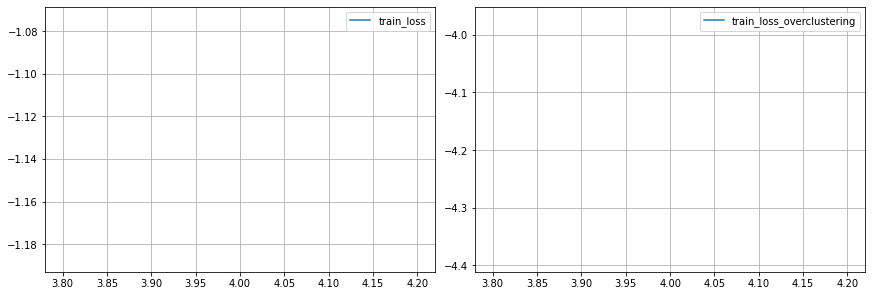

Epoch 6/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 7/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 8/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 9/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 10/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878]
[-4.18123, -4.348162]


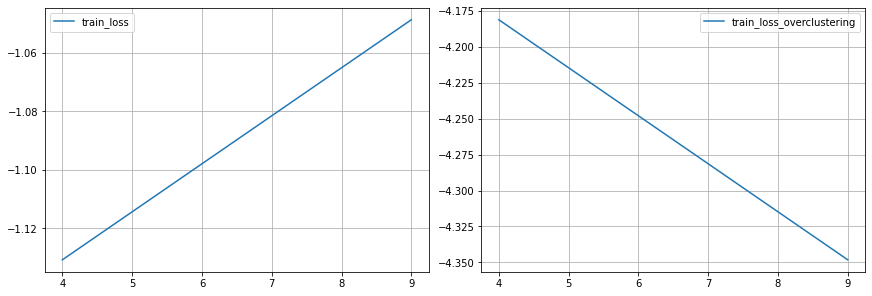

Epoch 11/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 12/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 13/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 14/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 15/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265]
[-4.18123, -4.348162, -3.5338604]


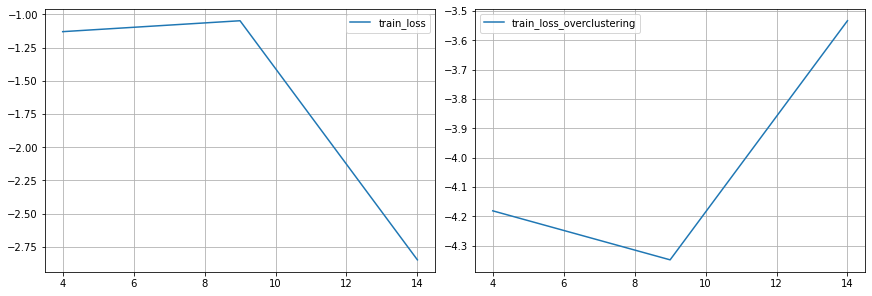

Epoch 16/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 17/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 18/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 19/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 20/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666]
[-4.18123, -4.348162, -3.5338604, -3.502896]


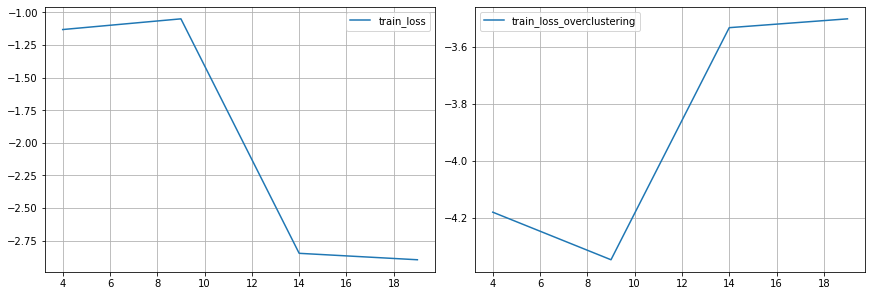

Epoch 21/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 22/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 23/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 24/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 25/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746]


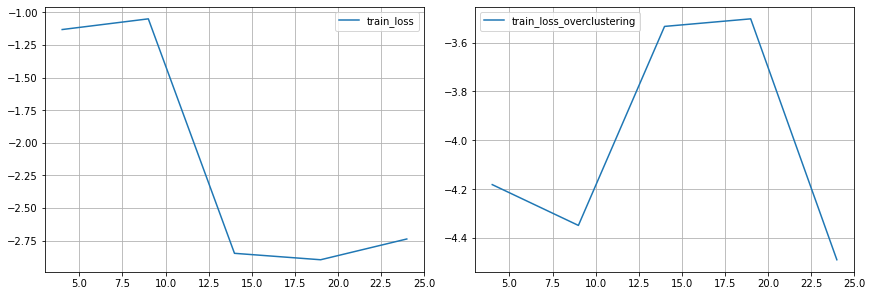

Epoch 26/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 27/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 28/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 29/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 30/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663]


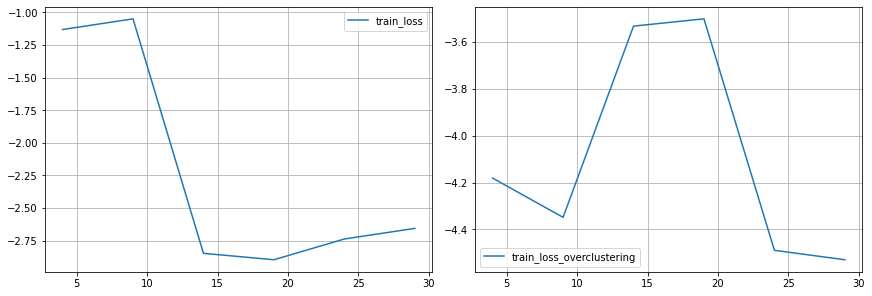

Epoch 31/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 32/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 33/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 34/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 35/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639]


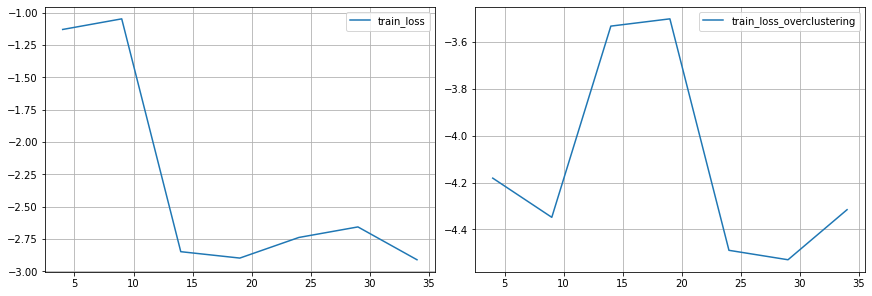

Epoch 36/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 37/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 38/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 39/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 40/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546]


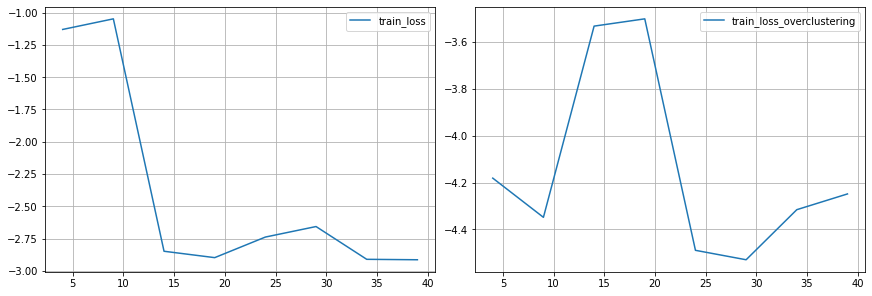

Epoch 41/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 42/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 43/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 44/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 45/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003]


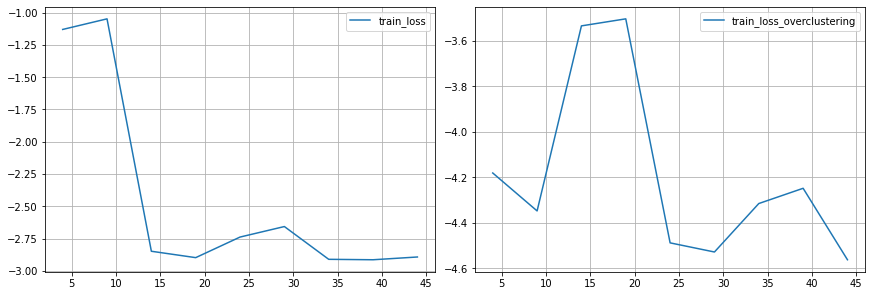

Epoch 46/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 47/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 48/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 49/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 50/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183]


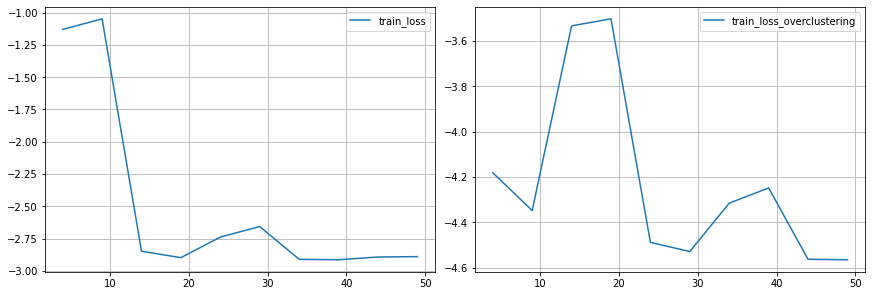

Epoch 51/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 52/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 53/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 54/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 55/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036]


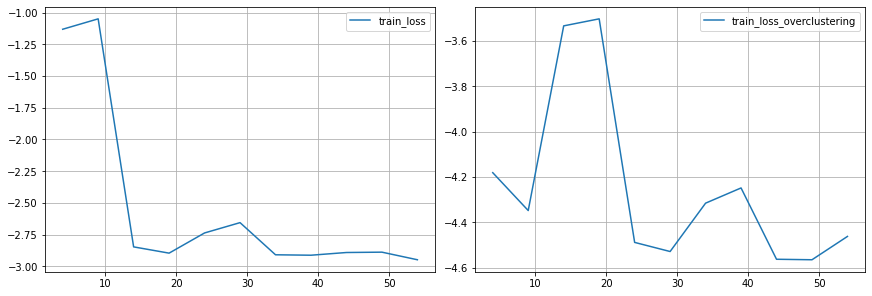

Epoch 56/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 57/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 58/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 59/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 60/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433]


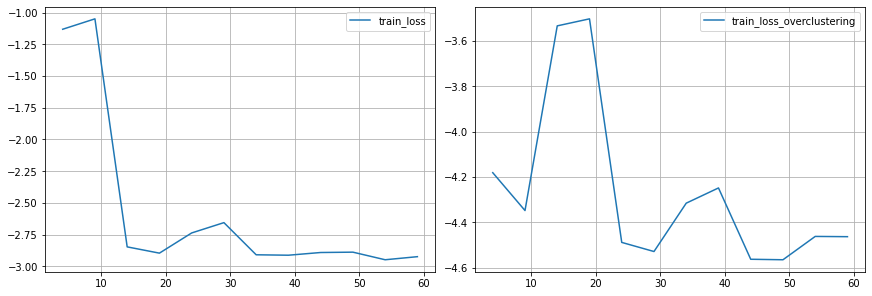

Epoch 61/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 62/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 63/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 64/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 65/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546, -2.9315712]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433, -4.604865]


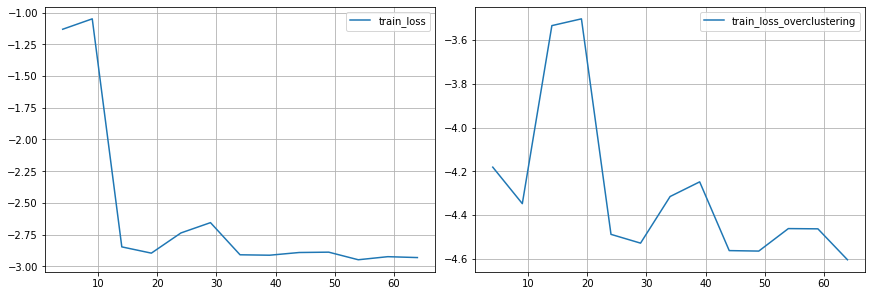

Epoch 66/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 67/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 68/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 69/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 70/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546, -2.9315712, -2.921836]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433, -4.604865, -4.590219]


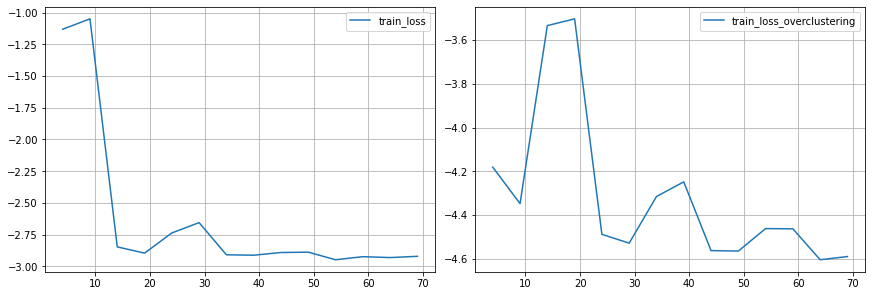

Epoch 71/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 72/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 73/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 74/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 75/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546, -2.9315712, -2.921836, -2.956063]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433, -4.604865, -4.590219, -4.5718074]


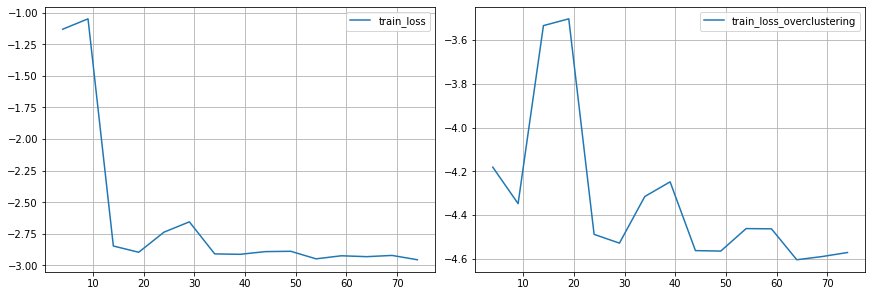

Epoch 76/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 77/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 78/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 79/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 80/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546, -2.9315712, -2.921836, -2.956063, -2.9321623]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433, -4.604865, -4.590219, -4.5718074, -4.5283637]


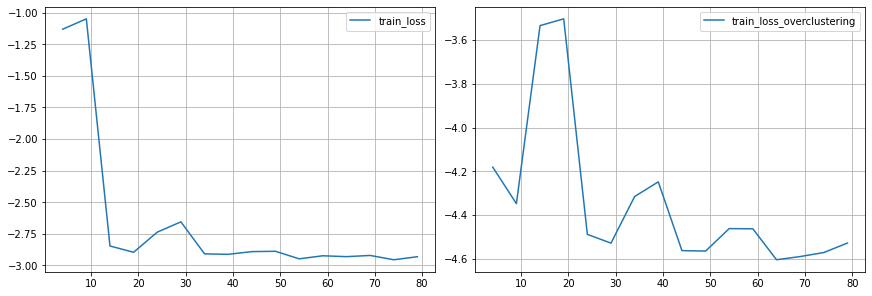

Epoch 81/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 82/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 83/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 84/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 85/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546, -2.9315712, -2.921836, -2.956063, -2.9321623, -2.96577]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433, -4.604865, -4.590219, -4.5718074, -4.5283637, -4.6139507]


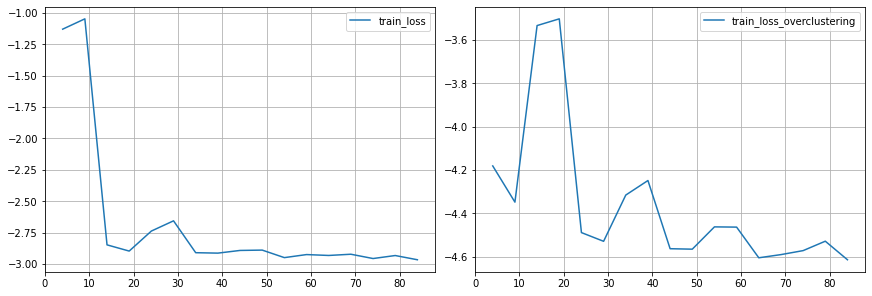

Epoch 86/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 87/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 88/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 89/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 90/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546, -2.9315712, -2.921836, -2.956063, -2.9321623, -2.96577, -2.925265]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433, -4.604865, -4.590219, -4.5718074, -4.5283637, -4.6139507, -4.635983]


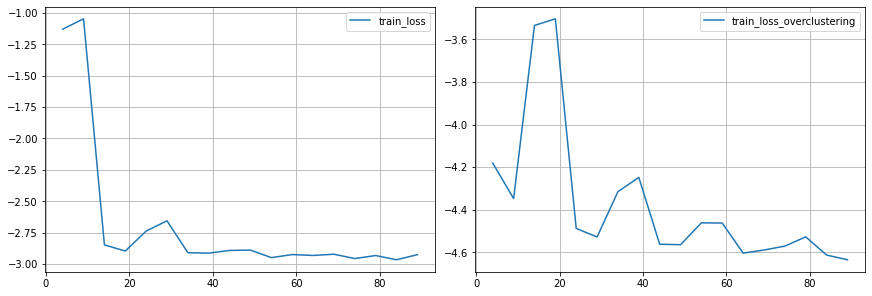

Epoch 91/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 92/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 93/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 94/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 95/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546, -2.9315712, -2.921836, -2.956063, -2.9321623, -2.96577, -2.925265, -2.966096]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433, -4.604865, -4.590219, -4.5718074, -4.5283637, -4.6139507, -4.635983, -4.571604]


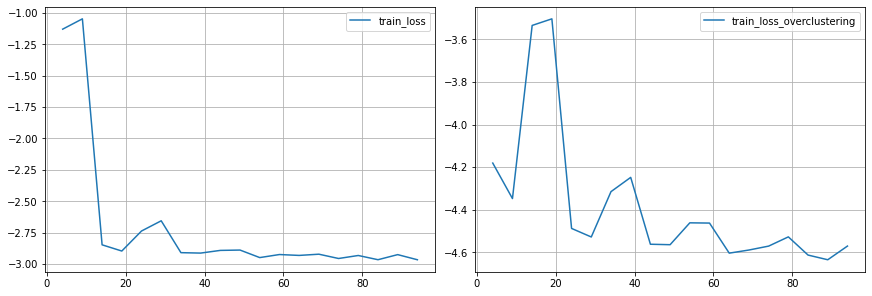

Epoch 96/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 97/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 98/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 99/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 100/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546, -2.9315712, -2.921836, -2.956063, -2.9321623, -2.96577, -2.925265, -2.966096, -2.9747374]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433, -4.604865, -4.590219, -4.5718074, -4.5283637, -4.6139507, -4.635983, -4.571604, -4.491647]


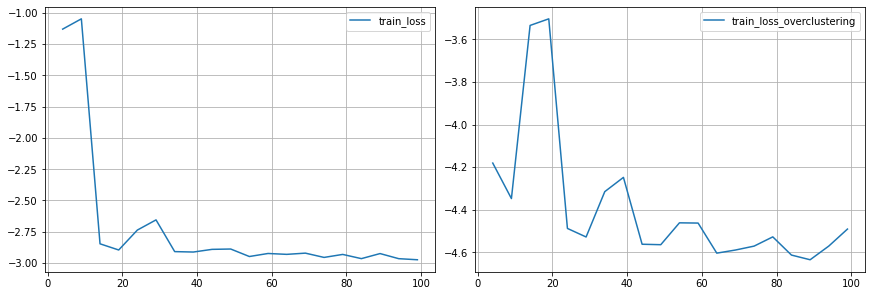

Epoch 101/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 102/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 103/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 104/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 105/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546, -2.9315712, -2.921836, -2.956063, -2.9321623, -2.96577, -2.925265, -2.966096, -2.9747374, -2.9520702]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433, -4.604865, -4.590219, -4.5718074, -4.5283637, -4.6139507, -4.635983, -4.571604, -4.491647, -4.604009]


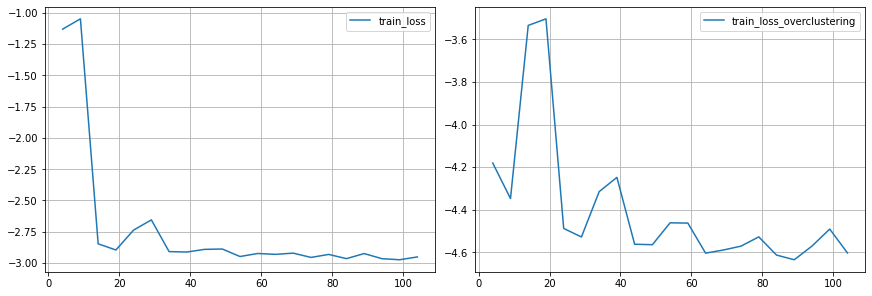

Epoch 106/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 107/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 108/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 109/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 110/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546, -2.9315712, -2.921836, -2.956063, -2.9321623, -2.96577, -2.925265, -2.966096, -2.9747374, -2.9520702, -2.983119]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433, -4.604865, -4.590219, -4.5718074, -4.5283637, -4.6139507, -4.635983, -4.571604, -4.491647, -4.604009, -4.6483665]


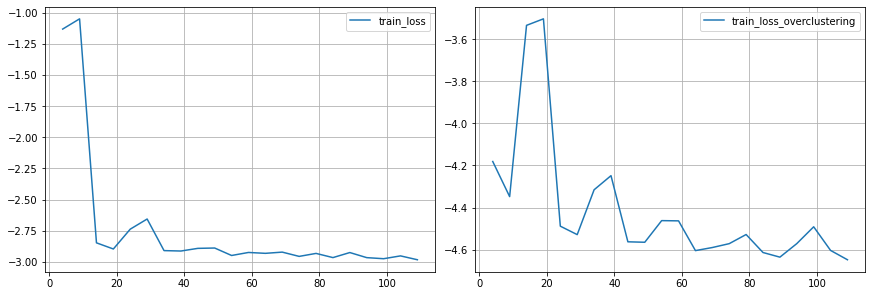

Epoch 111/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 112/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 113/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 114/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 115/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546, -2.9315712, -2.921836, -2.956063, -2.9321623, -2.96577, -2.925265, -2.966096, -2.9747374, -2.9520702, -2.983119, -2.9796522]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433, -4.604865, -4.590219, -4.5718074, -4.5283637, -4.6139507, -4.635983, -4.571604, -4.491647, -4.604009, -4.6483665, -4.6331725]


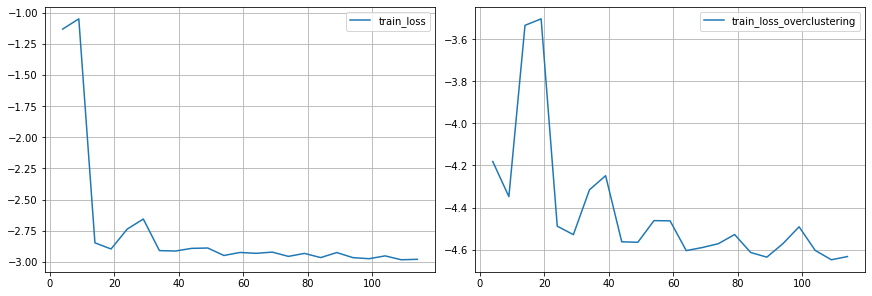

Epoch 116/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 117/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 118/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 119/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 120/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546, -2.9315712, -2.921836, -2.956063, -2.9321623, -2.96577, -2.925265, -2.966096, -2.9747374, -2.9520702, -2.983119, -2.9796522, -2.979415]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433, -4.604865, -4.590219, -4.5718074, -4.5283637, -4.6139507, -4.635983, -4.571604, -4.491647, -4.604009, -4.6483665, -4.6331725, -4.565]


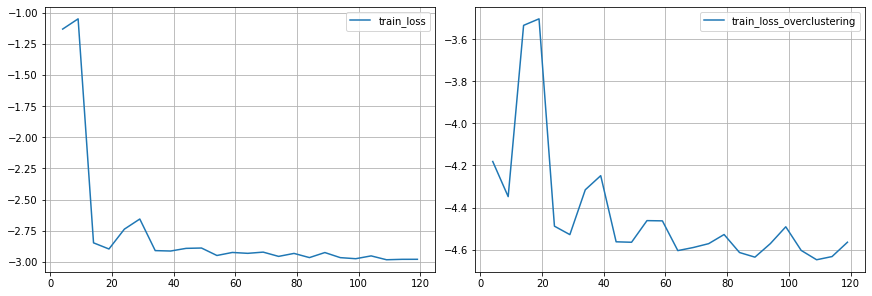

Epoch 121/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 122/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 123/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 124/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 125/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546, -2.9315712, -2.921836, -2.956063, -2.9321623, -2.96577, -2.925265, -2.966096, -2.9747374, -2.9520702, -2.983119, -2.9796522, -2.979415, -2.982707]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433, -4.604865, -4.590219, -4.5718074, -4.5283637, -4.6139507, -4.635983, -4.571604, -4.491647, -4.604009, -4.6483665, -4.6331725, -4.565, -4.643022]


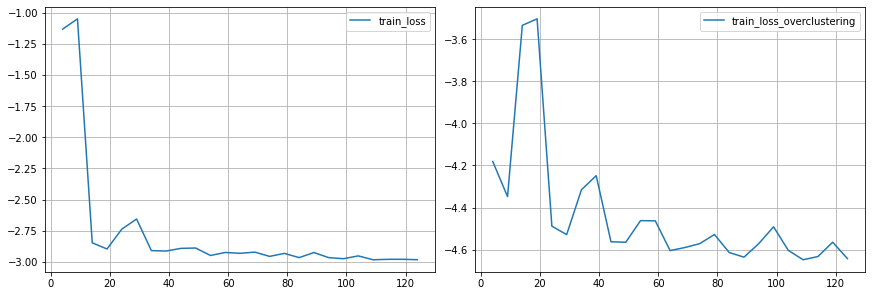

Epoch 126/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 127/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 128/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 129/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 130/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546, -2.9315712, -2.921836, -2.956063, -2.9321623, -2.96577, -2.925265, -2.966096, -2.9747374, -2.9520702, -2.983119, -2.9796522, -2.979415, -2.982707, -2.98325]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433, -4.604865, -4.590219, -4.5718074, -4.5283637, -4.6139507, -4.635983, -4.571604, -4.491647, -4.604009, -4.6483665, -4.6331725, -4.565, -4.643022, -4.672302]


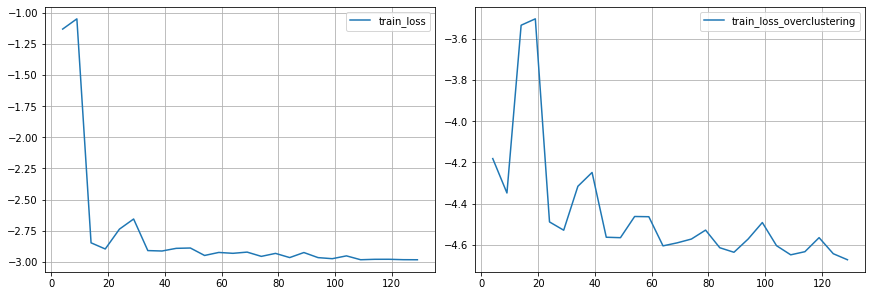

Epoch 131/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 132/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 133/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 134/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 135/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546, -2.9315712, -2.921836, -2.956063, -2.9321623, -2.96577, -2.925265, -2.966096, -2.9747374, -2.9520702, -2.983119, -2.9796522, -2.979415, -2.982707, -2.98325, -2.9986677]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433, -4.604865, -4.590219, -4.5718074, -4.5283637, -4.6139507, -4.635983, -4.571604, -4.491647, -4.604009, -4.6483665, -4.6331725, -4.565, -4.643022, -4.672302, -4.656061]


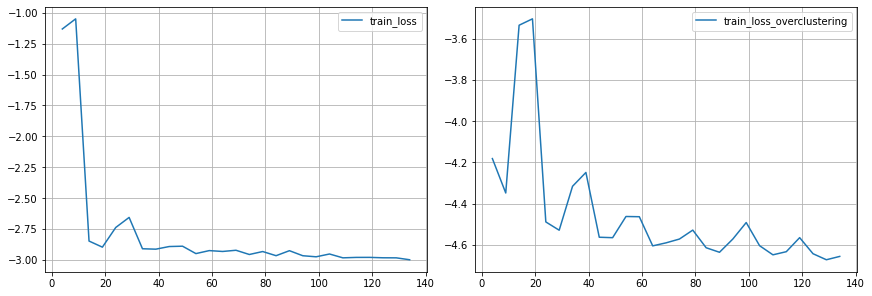

Epoch 136/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 137/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 138/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 139/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 140/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546, -2.9315712, -2.921836, -2.956063, -2.9321623, -2.96577, -2.925265, -2.966096, -2.9747374, -2.9520702, -2.983119, -2.9796522, -2.979415, -2.982707, -2.98325, -2.9986677, -2.9879055]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433, -4.604865, -4.590219, -4.5718074, -4.5283637, -4.6139507, -4.635983, -4.571604, -4.491647, -4.604009, -4.6483665, -4.6331725, -4.565, -4.643022, -4.672302, -4.656061, -4.5990505]


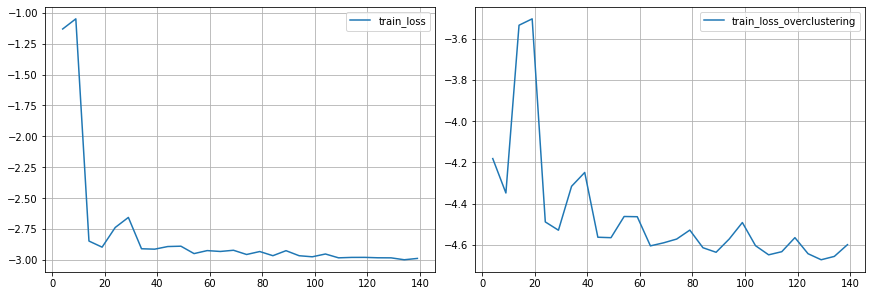

Epoch 141/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 142/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 143/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 144/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 145/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546, -2.9315712, -2.921836, -2.956063, -2.9321623, -2.96577, -2.925265, -2.966096, -2.9747374, -2.9520702, -2.983119, -2.9796522, -2.979415, -2.982707, -2.98325, -2.9986677, -2.9879055, -2.9795163]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433, -4.604865, -4.590219, -4.5718074, -4.5283637, -4.6139507, -4.635983, -4.571604, -4.491647, -4.604009, -4.6483665, -4.6331725, -4.565, -4.643022, -4.672302, -4.656061, -4.5990505, -4.616481]


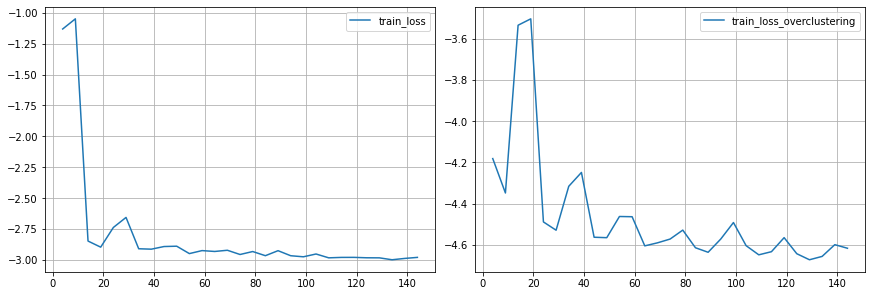

Epoch 146/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 147/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 148/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 149/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 150/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546, -2.9315712, -2.921836, -2.956063, -2.9321623, -2.96577, -2.925265, -2.966096, -2.9747374, -2.9520702, -2.983119, -2.9796522, -2.979415, -2.982707, -2.98325, -2.9986677, -2.9879055, -2.9795163, -2.9991405]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433, -4.604865, -4.590219, -4.5718074, -4.5283637, -4.6139507, -4.635983, -4.571604, -4.491647, -4.604009, -4.6483665, -4.6331725, -4.565, -4.643022, -4.672302, -4.656061, -4.5990505, -4.616481, -4.667025]


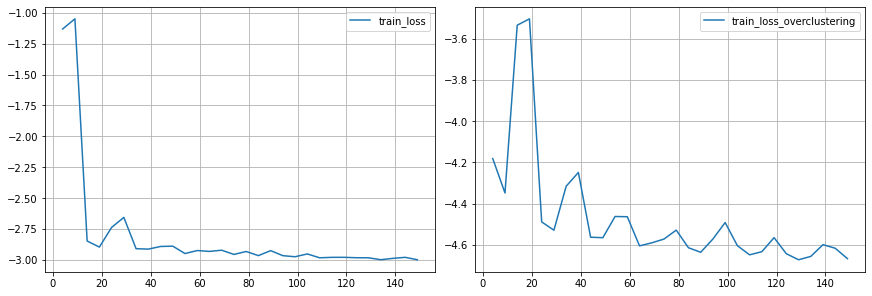

Epoch 151/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 152/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 153/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 154/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 155/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546, -2.9315712, -2.921836, -2.956063, -2.9321623, -2.96577, -2.925265, -2.966096, -2.9747374, -2.9520702, -2.983119, -2.9796522, -2.979415, -2.982707, -2.98325, -2.9986677, -2.9879055, -2.9795163, -2.9991405, -2.9718945]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433, -4.604865, -4.590219, -4.5718074, -4.5283637, -4.6139507, -4.635983, -4.571604, -4.491647, -4.604009, -4.6483665, -4.6331725, -4.565, -4.643022, -4.672302, -4.656061, -4.5990505, -4.616481, -4.667025, -4.5812497]


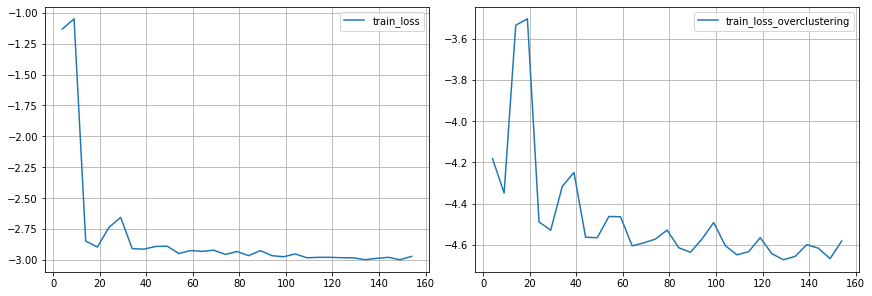

Epoch 156/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 157/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 158/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 159/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 160/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546, -2.9315712, -2.921836, -2.956063, -2.9321623, -2.96577, -2.925265, -2.966096, -2.9747374, -2.9520702, -2.983119, -2.9796522, -2.979415, -2.982707, -2.98325, -2.9986677, -2.9879055, -2.9795163, -2.9991405, -2.9718945, -2.9776037]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433, -4.604865, -4.590219, -4.5718074, -4.5283637, -4.6139507, -4.635983, -4.571604, -4.491647, -4.604009, -4.6483665, -4.6331725, -4.565, -4.643022, -4.672302, -4.656061, -4.5990505, -4.616481, -4.667025, -4.5812497, -4.5811753]


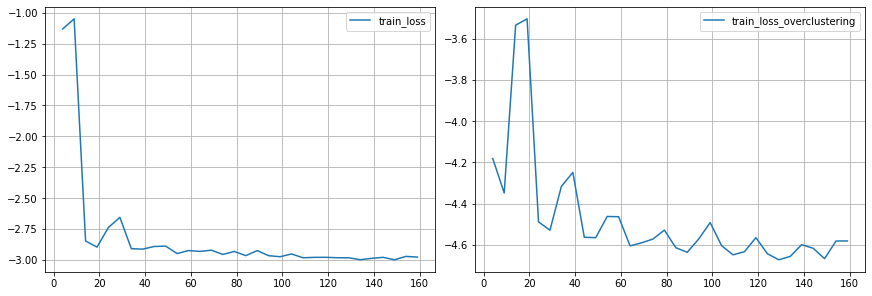

Epoch 161/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 162/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 163/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 164/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 165/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546, -2.9315712, -2.921836, -2.956063, -2.9321623, -2.96577, -2.925265, -2.966096, -2.9747374, -2.9520702, -2.983119, -2.9796522, -2.979415, -2.982707, -2.98325, -2.9986677, -2.9879055, -2.9795163, -2.9991405, -2.9718945, -2.9776037, -2.9872143]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433, -4.604865, -4.590219, -4.5718074, -4.5283637, -4.6139507, -4.635983, -4.571604, -4.491647, -4.604009, -4.6483665, -4.6331725, -4.565, -4.643022, -4.672302, -4.656061, -4.5990505, -4.616481, -4.667025, -4.5812497, -4.5811753, -4.615789]


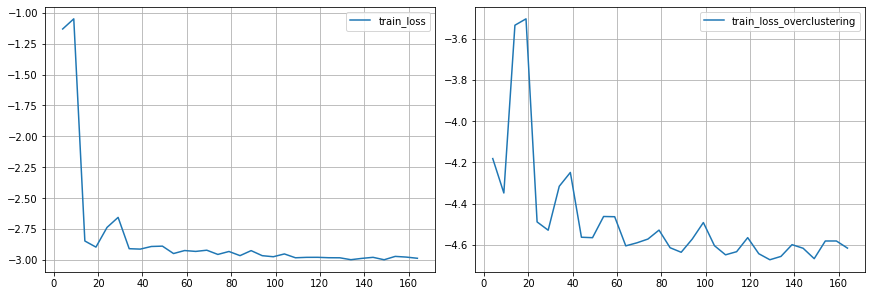

Epoch 166/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 167/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 168/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 169/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 170/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546, -2.9315712, -2.921836, -2.956063, -2.9321623, -2.96577, -2.925265, -2.966096, -2.9747374, -2.9520702, -2.983119, -2.9796522, -2.979415, -2.982707, -2.98325, -2.9986677, -2.9879055, -2.9795163, -2.9991405, -2.9718945, -2.9776037, -2.9872143, -2.9846623]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433, -4.604865, -4.590219, -4.5718074, -4.5283637, -4.6139507, -4.635983, -4.571604, -4.491647, -4.604009, -4.6483665, -4.6331725, -4.565, -4.643022, -4.672302, -4.656061, -4.5990505, -4.616481, -4.667025, -4.5812497, -4.5811753, -4.615789, -4.647259]


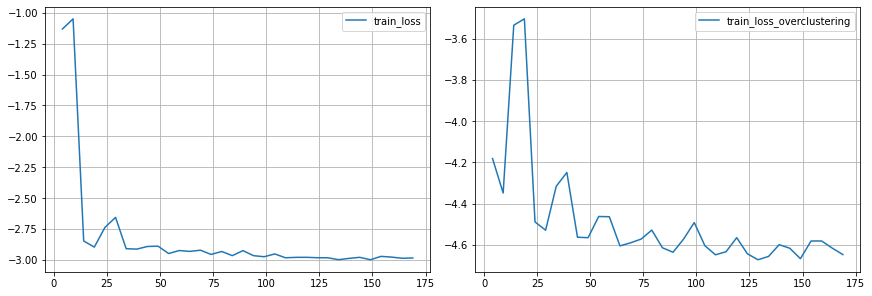

Epoch 171/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 172/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 173/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 174/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 175/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546, -2.9315712, -2.921836, -2.956063, -2.9321623, -2.96577, -2.925265, -2.966096, -2.9747374, -2.9520702, -2.983119, -2.9796522, -2.979415, -2.982707, -2.98325, -2.9986677, -2.9879055, -2.9795163, -2.9991405, -2.9718945, -2.9776037, -2.9872143, -2.9846623, -2.9922886]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433, -4.604865, -4.590219, -4.5718074, -4.5283637, -4.6139507, -4.635983, -4.571604, -4.491647, -4.604009, -4.6483665, -4.6331725, -4.565, -4.643022, -4.672302, -4.656061, -4.5990505, -4.616481, -4.667025, -4.5812497, -4.5811753, -4.615789, -4.647259, -4.655015]


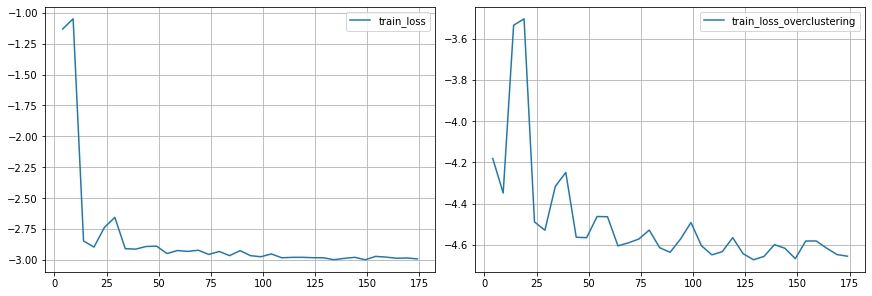

Epoch 176/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 177/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 178/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 179/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 180/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546, -2.9315712, -2.921836, -2.956063, -2.9321623, -2.96577, -2.925265, -2.966096, -2.9747374, -2.9520702, -2.983119, -2.9796522, -2.979415, -2.982707, -2.98325, -2.9986677, -2.9879055, -2.9795163, -2.9991405, -2.9718945, -2.9776037, -2.9872143, -2.9846623, -2.9922886, -2.9996135]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433, -4.604865, -4.590219, -4.5718074, -4.5283637, -4.6139507, -4.635983, -4.571604, -4.491647, -4.604009, -4.6483665, -4.6331725, -4.565, -4.643022, -4.672302, -4.656061, -4.5990505, -4.616481, -4.667025, -4.5812497, -4.5811753, -4.615789, -4.647259, -4.655015, -4.66294]


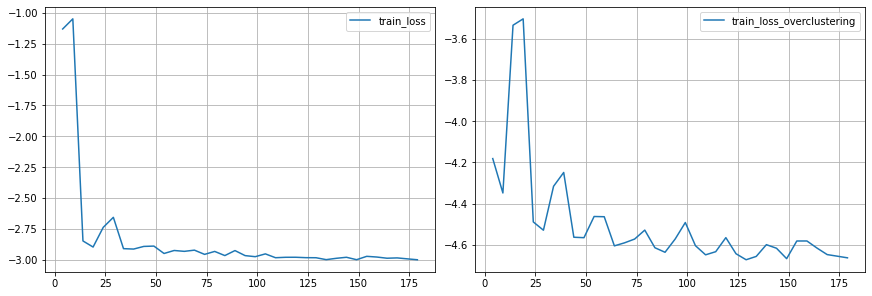

Epoch 181/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 182/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 183/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 184/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 185/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546, -2.9315712, -2.921836, -2.956063, -2.9321623, -2.96577, -2.925265, -2.966096, -2.9747374, -2.9520702, -2.983119, -2.9796522, -2.979415, -2.982707, -2.98325, -2.9986677, -2.9879055, -2.9795163, -2.9991405, -2.9718945, -2.9776037, -2.9872143, -2.9846623, -2.9922886, -2.9996135, -2.9610379]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433, -4.604865, -4.590219, -4.5718074, -4.5283637, -4.6139507, -4.635983, -4.571604, -4.491647, -4.604009, -4.6483665, -4.6331725, -4.565, -4.643022, -4.672302, -4.656061, -4.5990505, -4.616481, -4.667025, -4.5812497, -4.5811753, -4.615789, -4.647259, -4.655015, -4.66294, -4.6451755]


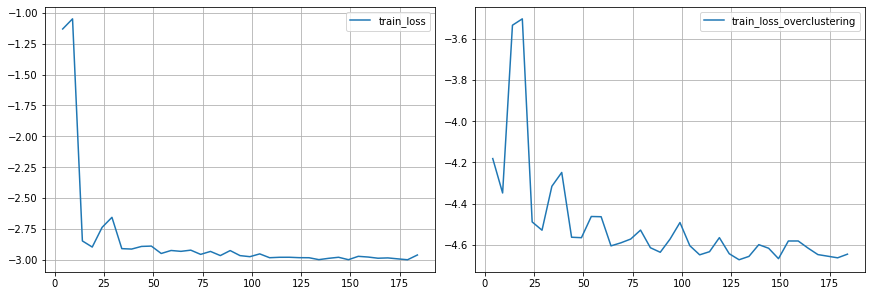

Epoch 186/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 187/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 188/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 189/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 190/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546, -2.9315712, -2.921836, -2.956063, -2.9321623, -2.96577, -2.925265, -2.966096, -2.9747374, -2.9520702, -2.983119, -2.9796522, -2.979415, -2.982707, -2.98325, -2.9986677, -2.9879055, -2.9795163, -2.9991405, -2.9718945, -2.9776037, -2.9872143, -2.9846623, -2.9922886, -2.9996135, -2.9610379, -2.9888668]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433, -4.604865, -4.590219, -4.5718074, -4.5283637, -4.6139507, -4.635983, -4.571604, -4.491647, -4.604009, -4.6483665, -4.6331725, -4.565, -4.643022, -4.672302, -4.656061, -4.5990505, -4.616481, -4.667025, -4.5812497, -4.5811753, -4.615789, -4.647259, -4.655015, -4.66294, -4.6451755, -4.6701016]


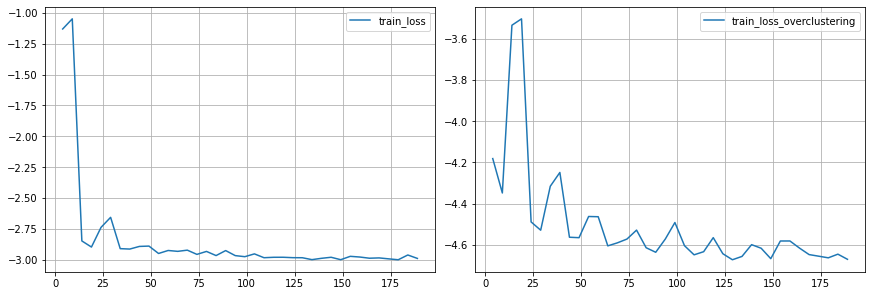

Epoch 191/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 192/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 193/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 194/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 195/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546, -2.9315712, -2.921836, -2.956063, -2.9321623, -2.96577, -2.925265, -2.966096, -2.9747374, -2.9520702, -2.983119, -2.9796522, -2.979415, -2.982707, -2.98325, -2.9986677, -2.9879055, -2.9795163, -2.9991405, -2.9718945, -2.9776037, -2.9872143, -2.9846623, -2.9922886, -2.9996135, -2.9610379, -2.9888668, -2.988576]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433, -4.604865, -4.590219, -4.5718074, -4.5283637, -4.6139507, -4.635983, -4.571604, -4.491647, -4.604009, -4.6483665, -4.6331725, -4.565, -4.643022, -4.672302, -4.656061, -4.5990505, -4.616481, -4.667025, -4.5812497, -4.5811753, -4.615789, -4.647259, -4.655015, -4.66294, -4.6451755, -4.6701016, -4.645991]


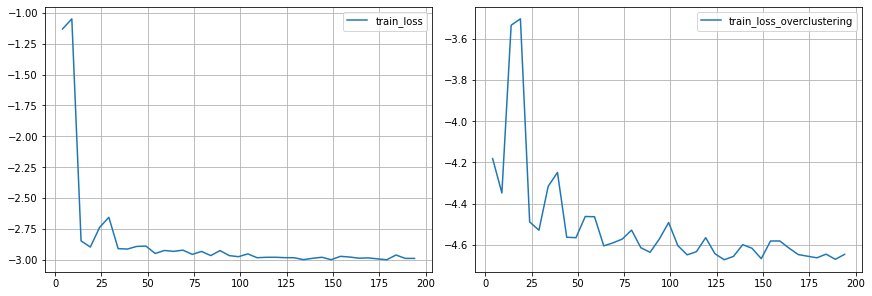

Epoch 196/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 197/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 198/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 199/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 200/200:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.1307434, -1.0486878, -2.847265, -2.89666, -2.7373857, -2.6560214, -2.9096346, -2.9130237, -2.89165, -2.8889306, -2.9488251, -2.9245546, -2.9315712, -2.921836, -2.956063, -2.9321623, -2.96577, -2.925265, -2.966096, -2.9747374, -2.9520702, -2.983119, -2.9796522, -2.979415, -2.982707, -2.98325, -2.9986677, -2.9879055, -2.9795163, -2.9991405, -2.9718945, -2.9776037, -2.9872143, -2.9846623, -2.9922886, -2.9996135, -2.9610379, -2.9888668, -2.988576, -3.0036747]
[-4.18123, -4.348162, -3.5338604, -3.502896, -4.4886746, -4.5288663, -4.315639, -4.248546, -4.563003, -4.565183, -4.4623036, -4.4634433, -4.604865, -4.590219, -4.5718074, -4.5283637, -4.6139507, -4.635983, -4.571604, -4.491647, -4.604009, -4.6483665, -4.6331725, -4.565, -4.643022, -4.672302, -4.656061, -4.5990505, -4.616481, -4.667025, -4.5812497, -4.5811753, -4.615789, -4.647259, -4.655015, -4.66294, -4.6451755, -4.6701016, -4.645991, -4.6757746]


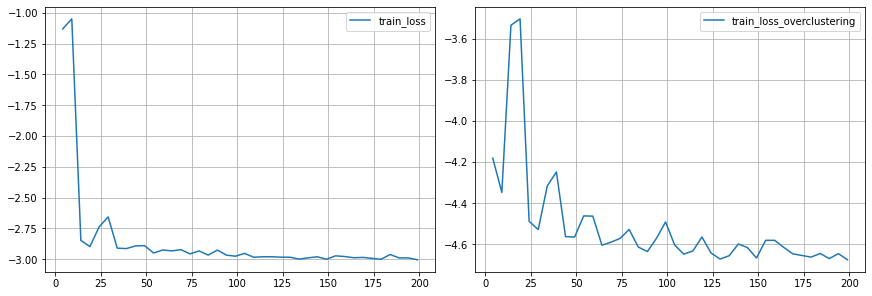

Best Clustering Loss Value: -3.0036747


In [ ]:
# training
optimizer = torch.optim.Adam(
    model.parameters(), lr=4e-4, betas=(0.9, 0.999), eps=1e-08,
    weight_decay=0, amsgrad=False)

train( model, dataloader_train, dataloader_val,
    optimizer, device=device, epochs=200, lamb=1.2,
    overcluster_period=20, overcluster_ratio=0.5)

**Loading best model**

In [ ]:
test_model = ResNetClusterisator()
test_model.load_state_dict(torch.load("/content/best_loss_model_mnist.pth"))
test_model.to(device)

ResNetClusterisator(
  (backbone): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [ ]:
# data testing
original_labels, cluster_labels = model_test(
    test_model, dataloader_val, device=device
)

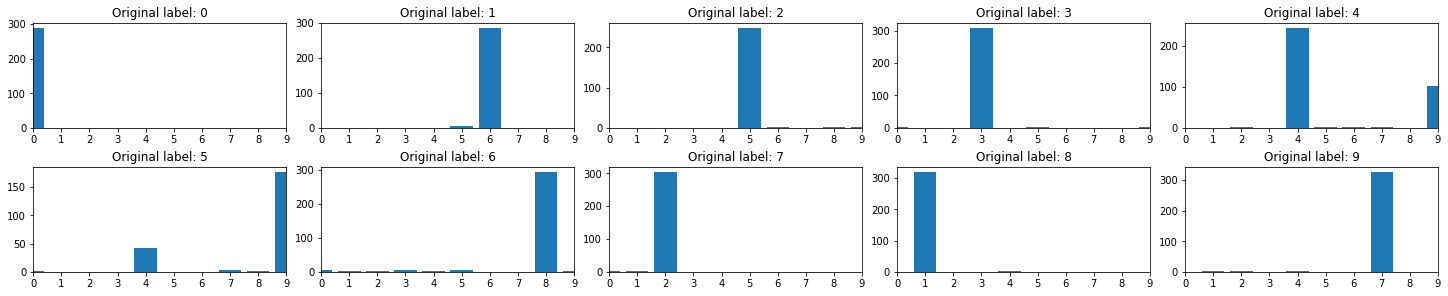

In [ ]:
# visualization
visualise_clusetering_results(original_labels, cluster_labels)

In [ ]:
adj_score = adjusted_rand_score(cluster_labels, original_labels)
hom_score = homogeneity_score(cluster_labels, original_labels)
compl_score = completeness_score(cluster_labels, original_labels)
print("Adjusted rand score: %.3f " % adj_score)
print("Homogeneity score: %.3f " % adj_score)
print("Completeness score: %.3f" % compl_score)

Adjusted rand score: 0.885 
Homogeneity score: 0.885 
Completeness score: 0.907


In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score(np.array(cluster_labels).reshape(-1, 1), np.array(original_labels).reshape(-1, 1))

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7885715442711921

In [ ]:
accuracy_score(original_labels, cluster_labels)

0.2806666666666667